This notebook demonstrates how to:
- build a [RASA](https://rasahq.github.io) pipeline, 
- train it,
- and generate slot predictions.

# Prep

In [ ]:
!python -m spacy download en_core_web_md
!pip install rasa 

In [3]:
import os
import matplotlib.pyplot as plt
from rasa.nlu.model import Trainer
from rasa.nlu.test import run_evaluation
from rasa.nlu import config
from rasa.shared.nlu.training_data.loading import load_data
import random
import time

woz_directory ="data/"

def trainModel(pipeline,model_dir):
    path_to_data = "data/rasa_train.json" # sentences in training set, pre-processed
    training_data = load_data(path_to_data)
    trainer = Trainer(config.load(pipeline))
    interpreter = trainer.train(training_data)
    path_to_model = "models/current/"+model_dir
    model_directory = trainer.persist(path_to_model)

    return model_directory, interpreter


In [ ]:
split = 'train'
def get_data(split):
    train_data = []
    ents = set()
    ints = set()
    with open(woz_directory + f"WOZ_{split}_utt.txt") as f1:
        with open(woz_directory + f"WOZ_{split}_ans.txt") as f2:
            for l1, l2 in zip(f1.readlines(), f2.readlines()):
                try:
                    temp = {}
                    sent = l1.strip()
                    labels = l2.strip().split('|')

                    temp['sentence'] = sent
                    temp['intent'] = labels[0]
                    ints.add(labels[0])
                    temp['entities'] = {}
                    if len(labels) > 1:
                        for l in labels[1:]:
                            ent, val = l.split('=')
                            temp['entities'][ent] = val
 
                    train_data.append(temp)
                except Exception as e:
                    print(e)
    for i, data in enumerate(train_data):
        sent = data['sentence'].split()
        obj = []
        for word in sent:
            lab = 'O'
            if len(word) >=4:
                for k, v in temp['entities'].items():
                    if  word.lower() in v.lower() :
                        lab = k
                    elif word.lower() in k.lower() :
                        lab = k
            obj.append(lab)

        train_data[i]['labels'] = obj

    l = []
    for d in train_data:
        ents = []
        s = d['sentence'].lower()
        for e in d['entities']:
            start = 0
            end = -1
            if d['entities'][e].lower() in d['sentence'].lower():
                
                start = s.find(d['entities'][e])
                print(start)
                end = start+len(d['entities'][e].lower())
            else:
                ee = e.split('-')[-1]
                if ee in d['sentence'].lower():
                    start = s.find(ee)
                    end = start+len(ee)
            ents.append({
            "start": start,
            "end": end,
            "value": d['entities'][e],
            "entity": e
          })
        l.append({"text":d['sentence'], "intent":d['intent'], 'entities': ents})
    return {"rasa_nlu_data": {"common_examples": l}}
RASA_TRAIN_DATA = get_data('train')
with open(woz_directory+f'rasa_train.json', 'w') as f:
    json.dump(RASA_TRAIN_DATA, f, indent=4)


In [5]:
start = time.time()
model_dir, interpreter = trainModel("config.yml","tf_model")
end = time.time()
print("The training took ", (end-start)/60, " mins")

print(model_dir)

The training took  57.19239163398743  mins
/content/models/current/tf_model/nlu_20210425-024821


# load file and train

In [6]:
import json
from collections import OrderedDict
from sklearn.metrics import accuracy_score


with open(woz_directory + "WOZ_dev_ans.txt") as f:
    dev_correct = [answer.strip() for answer  in f.readlines()]    

pred = []
for d in dev:
    test_sent = d['text']
    result = interpreter.parse(test_sent, only_output_properties=False)
    intent = result['intent']['name']
    ents = [intent]
    dict_ents = {}
    for ent in result['entities']:
        entity = ent["value"]
        if 'wifi' in ent or 'parking' in ent: 
            entity = "yes"
        
        ents.append(f'{ent["entity"]}={entity}')
        dict_ents[ent["entity"]] = entity
    dict1 = OrderedDict(sorted(dict_ents.items()))
    p = [intent] + [f'{k}={v}' for k, v in dict1.items()]
    pred.append('|'.join(p))


accuracy_score(pred, dev_correct)

# dev accuracy

0.6949152542372882

# Try configurations

In [7]:
print(open('config.yml', "r").read())

language: "en_core_web_sm"


pipeline:
  - name: SpacyNLP
    model: "en_core_web_sm"
  - name: SpacyTokenizer
  - name: RegexFeaturizer
  - name: LexicalSyntacticFeaturizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
    epochs: 1000
  - name: EntitySynonymMapper
  - name: ResponseSelector



In [ ]:
# config #1
language: "en"

pipeline:
  - name: WhitespaceTokenizer
  - name: RegexFeaturizer
  - name: LexicalSyntacticFeaturizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
  - name: EntitySynonymMapper
  - name: ResponseSelector


0.6634382566585957


# config #2
language: "en_core_web_sm"

pipeline:
  - name: SpacyNLP
    model: "en_core_web_sm"
  - name: SpacyTokenizer
  - name: RegexFeaturizer
  - name: LexicalSyntacticFeaturizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
  - name: EntitySynonymMapper
  - name: ResponseSelector


0.6731234866828087


# config #3
language: "en_core_web_sm"

pipeline:
  - name: SpacyNLP
    model: "en_core_web_sm"
  - name: SpacyTokenizer
  - name: RegexFeaturizer
  - name: LexicalSyntacticFeaturizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
    epochs: 500
  - name: EntitySynonymMapper
  - name: ResponseSelector

0.6924939467312349


# config #4, best so far
pipeline:
  - name: SpacyNLP
    model: "en_core_web_sm"
  - name: SpacyTokenizer
  - name: RegexFeaturizer
  - name: LexicalSyntacticFeaturizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
    epochs: 700
  - name: EntitySynonymMapper
  - name: ResponseSelector

0.6997578692493946


# Generate predictions on test set

In [8]:
with open("/content/WOZ_test_utt.txt", 'r') as f:
    lines = f.readlines()

In [36]:
test = []
for d in lines:
    test_sent = d.strip()
    result = interpreter.parse(test_sent, only_output_properties=False)
    intent = result['intent']['name']
    ents = [intent]
    dict_ents = {}
    for ent in result['entities']:
        entity = ent["value"]
        if 'wifi' in ent or 'parking' in ent: 
          if  "doesn't" not in test_sent and "don't" not in test_sent: 
            print("yess")
            entity = "yes"
          elif  "doesn't"  in test_sent or "don't"  in test_sent: 
            print('no')
            entity = "no"

        dict_ents[ent["entity"]] = entity
    dict1 = OrderedDict(sorted(dict_ents.items()))
    p = [intent] + [f'{k}={v}' for k, v in dict1.items()]
    test.append('|'.join(p))

In [ ]:
h = 'Id,Expected\n'
with open('TestSetPredictions.csv', 'w') as csv:
    csv.write(h)
    for i, t in enumerate(test):
        csv.write(f'{i},{t}\n')

# Check output

In [27]:
result['text']

"I need to get a guesthouse that doesn't have free parking"

In [1]:
tt = []
for l,t in zip(lines, test):
    print(l)
    print(t)
    c = input()
    if c!='':
        tt.append(c)
    else:
        tt.append(t)

Hello, I am looking for a restaurant in Cambridge. I believe it is called Golden Wok.

find_restaurant|restaurant-name=golden wok

Hi, I'm looking for a hotel to stay in that includes free wifi. I'm looking to stay in a hotel, not a guesthouse.

find_hotel|hotel-type=guesthouse


# Submit and check test score

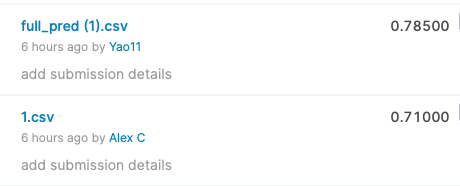